**SECTION 1: IMPORTING LIBS AND SETTING UP**

In [1]:
import numpy as np
import pandas as pd
import mediapipe as mp
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
print("a. TensorFlow Version :", tf.__version__)
print("b. GPU Availability   :", tf.config.list_physical_devices('GPU'))

a. TensorFlow Version : 2.19.0
b. GPU Availability   : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


**SECTION 2:** **CONFIGURATIONS**

In [2]:
# dataset config
DATASET_PATH = '../../asl_dataset_mediapipe' 
IMG_SIZE = 64
BATCH_SIZE = 32

In [3]:
def get_class_names_from_dataset(dataset_path):

    class_names = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]

    digits = sorted([c for c in class_names if c.isdigit()])
    letters = sorted([c for c in class_names if c.isalpha()])

    return digits + letters

CLASS_NAMES = get_class_names_from_dataset(DATASET_PATH)
NUM_CLASSES = len(CLASS_NAMES)
print(f"a. Number of classes: {NUM_CLASSES} \nb. Classes: {CLASS_NAMES}")

a. Number of classes: 36 
b. Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [4]:
# training config
MAX_EPOCHS = 100
DROPOUT_RATE = 0.4

**SECTION 3: DATA LOADING**

In [5]:
def load_dataset(dataset_path, img_size):
  # we use the pre-cropped mediapipe-annotated images here
    images = []
    labels = []
    class_counts = {}

    print("Loading the dataset . . . . .")

    for class_idx, class_name in enumerate(CLASS_NAMES):
        class_path = os.path.join(dataset_path, class_name)

        if not os.path.exists(class_path):
            print(f"❗Warning: Folder '{class_name}' not found!")
            continue

        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        class_counts[class_name] = len(image_files)

        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            img = cv2.imread(img_path)

            if img is None:
                print(f"❗Warning: Could not read {img_path}")
                continue
            #convert BRG (openCV) to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # just to verify here
            if img.shape[:2] != (img_size, img_size):
                img = cv2.resize(img, (img_size, img_size))

            images.append(img)
            labels.append(class_idx)

    # convert to numpy arrays
    images = np.array(images, dtype='float32')
    labels = np.array(labels)

    print(f"\nDATASET LOADED SUCCESSFULLY !")
    print(f"a. Total images: {len(images)}")
    print(f"b. Image shape : {images[0].shape}")
    print(f"c. Class distribution:")
    for class_name, count in class_counts.items():
        print(f"    {class_name}: {count} images")

    return images, labels, class_counts


In [6]:
# load the dataset
X, y, class_distribution = load_dataset(DATASET_PATH, IMG_SIZE)

Loading the dataset . . . . .

DATASET LOADED SUCCESSFULLY !
a. Total images: 7200
b. Image shape : (64, 64, 3)
c. Class distribution:
    0: 200 images
    1: 200 images
    2: 200 images
    3: 200 images
    4: 200 images
    5: 200 images
    6: 200 images
    7: 200 images
    8: 200 images
    9: 200 images
    A: 200 images
    B: 200 images
    C: 200 images
    D: 200 images
    E: 200 images
    F: 200 images
    G: 200 images
    H: 200 images
    I: 200 images
    J: 200 images
    K: 200 images
    L: 200 images
    M: 200 images
    N: 200 images
    O: 200 images
    P: 200 images
    Q: 200 images
    R: 200 images
    S: 200 images
    T: 200 images
    U: 200 images
    V: 200 images
    W: 200 images
    X: 200 images
    Y: 200 images
    Z: 200 images


**SECTION 4: DATA VISUALIZATION**

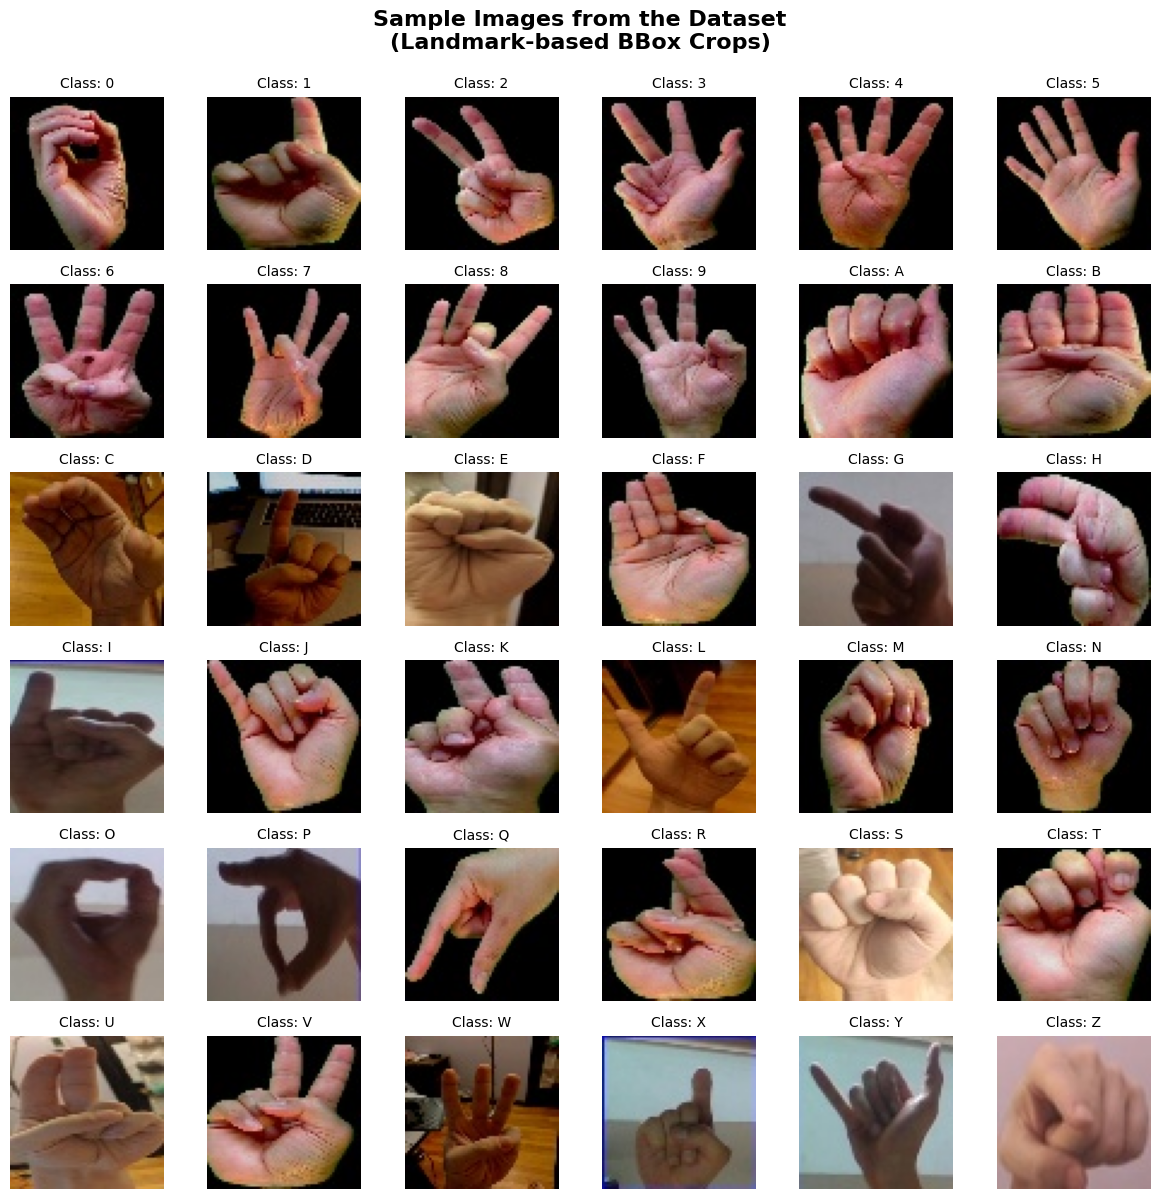

In [13]:
def visualize_samples(images, labels, class_names, samples_per_class=5):
    fig, axes = plt.subplots(6, 6, figsize=(12, 12))
    fig.suptitle('Sample Images from the Dataset\n(Landmark-based BBox Crops)', fontsize=16, y=0.995, fontweight='bold')

    for idx, class_idx in enumerate(range(min(36, len(class_names)))):
        class_images = images[labels == class_idx]

        if len(class_images) > 0:
            # pick any random sample pics
            sample_img = class_images[np.random.randint(0, len(class_images))]

            row = idx // 6
            col = idx % 6

            axes[row, col].imshow(sample_img.astype('uint8'))
            axes[row, col].set_title(f'Class: {class_names[class_idx]}', fontsize=10)
            axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()
visualize_samples(X, y, CLASS_NAMES)

**SECTION 5: DATA PREPROCESSING AND SPLITTING**

In [7]:
print(f"🐥 Image value range BEFORE normalization: [{X.min():.2f}, {X.max():.2f}]")
X = X / 255.0
print(f"🐥 Image value range AFTER normalization : [{X.min():.2f}, {X.max():.2f}]")

🐥 Image value range BEFORE normalization: [0.00, 255.00]
🐥 Image value range AFTER normalization : [0.00, 1.00]


In [8]:
# splittind dataset
X_train, X_temp, y_train, y_temp = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"a. Training set  : {len(X_train)} images ({len(X_train)/len(X)*100:.1f}%)")
print(f"b. Validation set: {len(X_val)} images ({len(X_val)/len(X)*100:.1f}%)")
print(f"c. Test set      : {len(X_test)} images ({len(X_test)/len(X)*100:.1f}%)")

a. Training set  : 5760 images (80.0%)
b. Validation set: 720 images (10.0%)
c. Test set      : 720 images (10.0%)


In [9]:
y_train_cat = to_categorical(y_train, NUM_CLASSES)
y_val_cat = to_categorical(y_val, NUM_CLASSES)
y_test_cat = to_categorical(y_test, NUM_CLASSES)

print("🐥 Labels converted with one-hot encoding !")

🐥 Labels converted with one-hot encoding !


Since the dataset is already well-curated from mediapipe cropping, data augmentation is to be omitted in this training.

**SECTION 6: MODEL ARCHITECTURE**

a. Model architecture:
  - Conv Block 1: 32 filters, filter-size=3x3
  - Conv Block 2: 64 filters
  - Conv Block 3: 128 filters
  - Dense layers: 256 -> 128 -> num_classes

b. Input: 64×64×3 images (MediaPipe landmark-based crops)  

In [ ]:
def build_cnn_model(input_shape, num_classes, dropout_rate=0.4):

    model = models.Sequential(name='ASL_CNN_MediaPipe')

    # conv block 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same', name='conv1_1')) 
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1_2')) 
    model.add(layers.MaxPooling2D((2, 2), name='pool1'))
    model.add(layers.Dropout(0.25, name='dropout1'))

    # conv block 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2_1'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2_2'))
    model.add(layers.MaxPooling2D((2, 2), name='pool2'))
    model.add(layers.Dropout(0.25, name='dropout2'))

    # conv block 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3'))
    model.add(layers.MaxPooling2D((2, 2), name='pool3'))
    model.add(layers.Dropout(dropout_rate, name='dropout3'))

    # dense layer
    model.add(layers.Flatten(name='flatten'))
    model.add(layers.Dense(256, activation='relu', name='dense1'))
    model.add(layers.Dropout(0.5, name='dropout4'))
    model.add(layers.Dense(128, activation='relu', name='dense2'))
    model.add(layers.Dropout(0.5, name='dropout5'))
    model.add(layers.Dense(num_classes, activation='softmax', name='output'))

    return model

In [11]:
print("BUILDING CNN MODEL . . . . .\n")
model = build_cnn_model(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    num_classes=NUM_CLASSES,
    dropout_rate=DROPOUT_RATE
)
model.summary()
total_params = model.count_params()
print(f"\nTOTAL PARAMETERS: {total_params:,}")

BUILDING CNN MODEL . . . . .



Model: "ASL_CNN_MediaPipe"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_1 (Conv2D)                │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout4 (Dropout)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout5 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,274,372 (8.68 MB)

 Trainable params: 2,274,372 (8.68 MB)

 Non-trainable params: 0 (0.00 B)


TOTAL PARAMETERS: 2,274,372


**SECTION 7: MODEL COMPILATION**

In [12]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("🐥 Model compiled with Adam optimizer (lr=0.001)")

🐥 Model compiled with Adam optimizer (lr=0.001)


**SECTION 8: CALLBACKS SETTING UP**

In [ ]:
# low train & val loss = good generalization
# early stopping in case val loss does not improve
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# reduce lr when val lose plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# model checkpoint: save best model at the highest epoch
checkpoint = ModelCheckpoint(
    'best_asl_cnn_mediapipe_model.h5', # saves with optimizer state + extra metadata
    # due to its size of 26MB and including optimizer, its good to use for later training resumption
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

callbacks = [early_stop, reduce_lr, checkpoint]

**SECTION 9: MODEL TRAINING**

In [ ]:
print("🐥 STARTING TRAINING")

# steps per epoch
steps_per_epoch = len(X_train) // BATCH_SIZE

print(f"Training configuration:")
print(f"a. Training samples: {len(X_train)}")
print(f"b. Batch size      : {BATCH_SIZE}")
print(f"c. Steps per epoch : {steps_per_epoch}")
print(f"d. Max epochs      : {MAX_EPOCHS}\n")

# train directly on normalized data
history = model.fit(
    X_train, y_train_cat,
    batch_size=BATCH_SIZE,
    epochs=MAX_EPOCHS,
    validation_data=(X_val, y_val_cat),
    callbacks=callbacks,
    verbose=1
)

print("🐔 TRAINING COMPLETED")

In [ ]:
'''
🐥 STARTING TRAINING
Training configuration:
a. Training samples: 5760
b. Batch size      : 32
c. Steps per epoch : 180
d. Max epochs      : 100

To see full training history, please refer to the training_history_cnn_mediapipe.csv file.
'''

**SECTION 10: TRAINING VISUALIZATION**

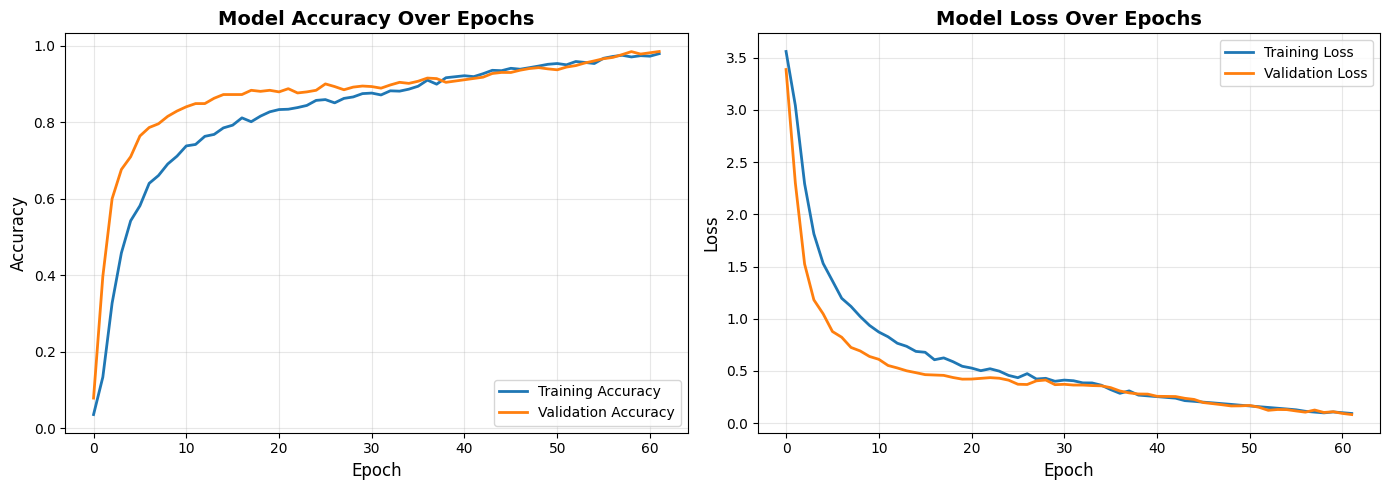

📊 Training Summary (from saved history):
a. Best epoch: 62
b. Best training accuracy: 0.9790 (97.90%)
c. Best validation accuracy: 0.9847 (98.47%)
d. Total epochs trained: 62


In [ ]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)

    # loss plot
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # best metrics
    best_epoch = np.argmax(history.history['val_accuracy'])
    best_val_acc = history.history['val_accuracy'][best_epoch]
    best_train_acc = history.history['accuracy'][best_epoch]

    print(f"\n📊 Training Summary:")
    print(f"a. Best epoch              : {best_epoch + 1}")
    print(f"b. Best training accuracy  : {best_train_acc:.4f} ({best_train_acc*100:.2f}%)")
    print(f"c. Best validation accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
    print(f"d. Total epochs trained    : {len(history.history['accuracy'])}")

plot_training_history(history)

**SECTION 11: MODEL EVALUATION ON TEST SET**

In [15]:
# load best model saved by check-point
model = keras.models.load_model('best_asl_cnn_mediapipe_model.h5')
print("🐥 MODEL LOADED !")

# evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=0)

print(f"Test Set Performance:")
print(f"a. Test Loss    : {test_loss:.4f}")
print(f"b. Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

🐥 MODEL LOADED !
Test Set Performance:
a. Test Loss    : 0.0867
b. Test Accuracy: 0.9792 (97.92%)


In [16]:
# get predictions
y_pred_probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

**SECTION 12: DETAILED CLASSIFICAION METRICS**

In [17]:
# classification report
print("                  CLASSIFICATION REPORT:")
print("-" * 60)
report = classification_report(y_test, y_pred, target_names=CLASS_NAMES, digits=4)
print(report)

                  CLASSIFICATION REPORT:
------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.9500    0.9500    0.9500        20
           1     1.0000    0.9500    0.9744        20
           2     1.0000    1.0000    1.0000        20
           3     1.0000    1.0000    1.0000        20
           4     0.9524    1.0000    0.9756        20
           5     1.0000    0.9500    0.9744        20
           6     1.0000    1.0000    1.0000        20
           7     1.0000    1.0000    1.0000        20
           8     1.0000    1.0000    1.0000        20
           9     1.0000    1.0000    1.0000        20
           A     0.9500    0.9500    0.9500        20
           B     1.0000    1.0000    1.0000        20
           C     0.9524    1.0000    0.9756        20
           D     1.0000    0.9500    0.9744        20
           E     1.0000    1.0000    1.0000        20
           F     1.0000    1.0000

In [18]:
# per-class accuracy
print("          PER-CLASS ACCURACY:")
print("-" * 40)
cm = confusion_matrix(y_test, y_pred)
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

for i, class_name in enumerate(CLASS_NAMES):
    print(f"  {class_name}: {per_class_accuracy[i]:.4f} ({per_class_accuracy[i]*100:.2f}%)")

          PER-CLASS ACCURACY:
----------------------------------------
  0: 0.9500 (95.00%)
  1: 0.9500 (95.00%)
  2: 1.0000 (100.00%)
  3: 1.0000 (100.00%)
  4: 1.0000 (100.00%)
  5: 0.9500 (95.00%)
  6: 1.0000 (100.00%)
  7: 1.0000 (100.00%)
  8: 1.0000 (100.00%)
  9: 1.0000 (100.00%)
  A: 0.9500 (95.00%)
  B: 1.0000 (100.00%)
  C: 1.0000 (100.00%)
  D: 0.9500 (95.00%)
  E: 1.0000 (100.00%)
  F: 1.0000 (100.00%)
  G: 1.0000 (100.00%)
  H: 1.0000 (100.00%)
  I: 1.0000 (100.00%)
  J: 1.0000 (100.00%)
  K: 1.0000 (100.00%)
  L: 1.0000 (100.00%)
  M: 1.0000 (100.00%)
  N: 0.9500 (95.00%)
  O: 0.9500 (95.00%)
  P: 0.9500 (95.00%)
  Q: 1.0000 (100.00%)
  R: 0.9000 (90.00%)
  S: 0.9500 (95.00%)
  T: 0.9500 (95.00%)
  U: 0.9500 (95.00%)
  V: 0.9500 (95.00%)
  W: 1.0000 (100.00%)
  X: 0.9500 (95.00%)
  Y: 1.0000 (100.00%)
  Z: 1.0000 (100.00%)


In [19]:
# average per-class accuracy
avg_per_class_acc = per_class_accuracy.mean()
print(f"Average per-class accuracy: {avg_per_class_acc:.4f} ({avg_per_class_acc*100:.2f}%)")

Average per-class accuracy: 0.9792 (97.92%)


**SECTION 13: CONFUSION MATRIX**

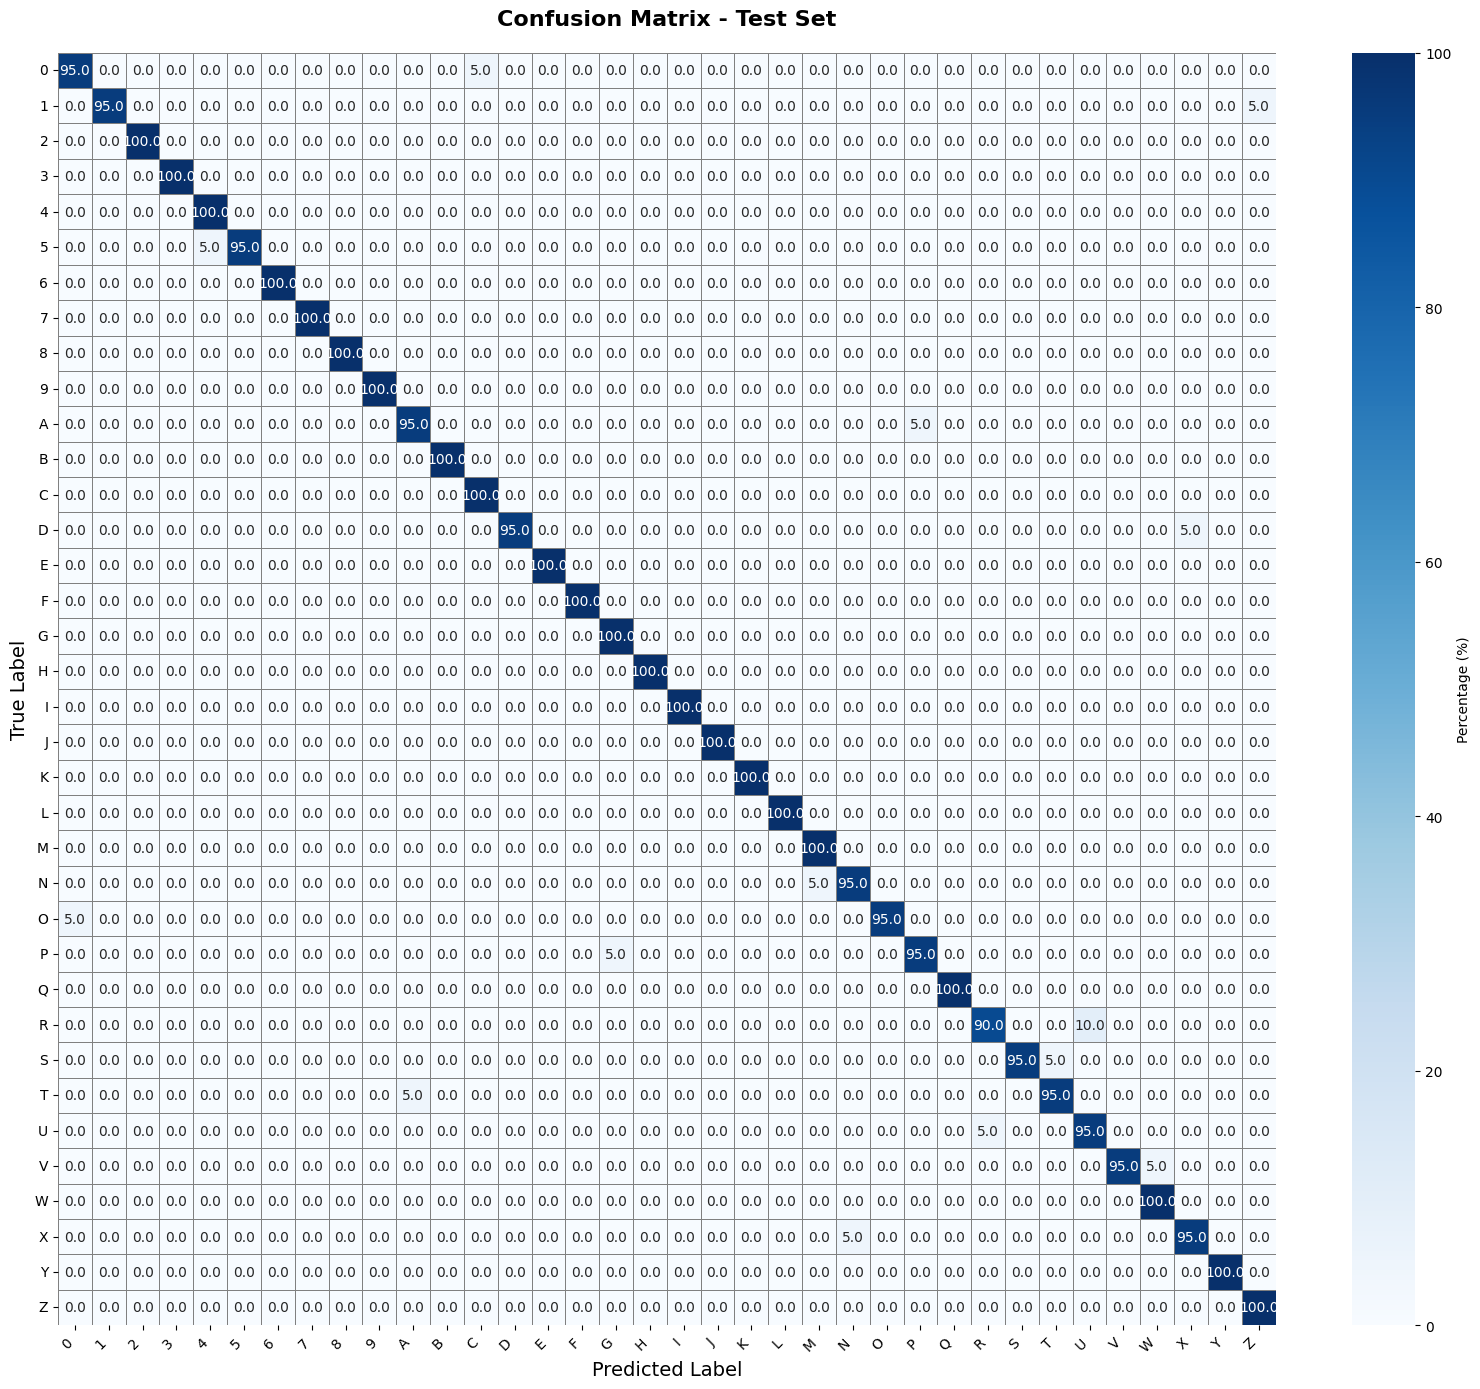


📊 Confusion Matrix Insights:
a. Most confused pair       : R -> U (10.0%)
b. Lowest performing class   : R (90.00%)
c. Highest performing class  : 2 (100.00%)
d. Average per-class accuracy: 97.92%


In [20]:
def plot_confusion_matrix_percentage(y_true, y_pred, class_names):
    # compute the matrix
    cm = confusion_matrix(y_true, y_pred)

    # convert to % (row-wise)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    plt.figure(figsize=(16, 14))

    sns.heatmap(cm_percentage, annot=True, fmt='.1f', cmap='Blues', xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Percentage (%)'}, linewidths=0.5, linecolor='gray')

    plt.title('Confusion Matrix - Test Set',
              fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    print("\n📊 Confusion Matrix Insights:")

    # most confused pairs
    np.fill_diagonal(cm_percentage, 0)  # we can ignore diagonal here
    most_confused_idx = np.unravel_index(cm_percentage.argmax(), cm_percentage.shape)
    most_confused_value = cm_percentage[most_confused_idx]

    print(f"a. Most confused pair       : {class_names[most_confused_idx[0]]} -> "
          f"{class_names[most_confused_idx[1]]} ({most_confused_value:.1f}%)")

    # classes with lowest accuracy
    cm_actual = confusion_matrix(y_true, y_pred)
    per_class_acc = cm_actual.diagonal() / cm_actual.sum(axis=1)
    worst_class_idx = np.argmin(per_class_acc)
    best_class_idx = np.argmax(per_class_acc)

    print(f"b. Lowest performing class   : {class_names[worst_class_idx]} "
          f"({per_class_acc[worst_class_idx]*100:.2f}%)")
    print(f"c. Highest performing class  : {class_names[best_class_idx]} "
          f"({per_class_acc[best_class_idx]*100:.2f}%)")

    # average accuracy
    print(f"d. Average per-class accuracy: {per_class_acc.mean()*100:.2f}%")

plot_confusion_matrix_percentage(y_test, y_pred, CLASS_NAMES)

**SECTION 14: SAVE FINAL MODEL**

In [ ]:
final_model_path = 'asl_final_cnn_mediapipe_model.h5'
model.save(final_model_path) # saves in HDF5 format with compression. for later versions of tensorflow, please refer to .keras model
print(f"🐥 Final model saved to: {final_model_path}") 

# save model architecture as JSON
model_json = model.to_json()
with open('asl_cnn_mediapipe_model_architecture.json', 'w') as json_file:
    json_file.write(model_json)
print("🍔 Model architecture saved to: asl_cnn_mediapipe_model_architecture.json")

# save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history_cnn_mediapipe.csv', index=False)
print("🐔 Training history saved to: training_history_cnn_mediapipe.csv")

🐥 Final model saved to: /content/drive/MyDrive/asl_dataset/asl_final_cnn_mediapipe_model.h5
🍔 Model architecture saved to: asl_cnn_mediapipe_model_architecture.json
🐔 Training history saved to: training_history_cnn_mediapipe.csv


**SECTION 15: TESTING WITH EXTERNAL IMAGES**

In [ ]:
def preprocess_external_image_with_mediapipe(img_path, img_size=64):
    # preprocess external image using MediaPipe (SAME as training preprocessing!)
    
    mp_hands = mp.solutions.hands
    mp_drawing = mp.solutions.drawing_utils
    hands = mp_hands.Hands(
        static_image_mode=True,
        max_num_hands=1,
        min_detection_confidence=0.3
    )

    img = cv2.imread(img_path)
    if img is None:
        print(f"❗Error: Could not read image: {img_path}")
        hands.close()
        return None, False, None

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img_rgb.shape

    # detect hand landmarks
    results = hands.process(img_rgb)
    viz_img = img_rgb.copy()

    if not results.multi_hand_landmarks:
        print(f"❗Warning: No hand detected in {img_path}")
        # using fallback center crop 
        size = min(h, w)
        start_y = (h - size) // 2
        start_x = (w - size) // 2
        cropped = img_rgb[start_y:start_y+size, start_x:start_x+size]

        # draw indicator on viz
        cv2.putText(viz_img, "No MediaPipe detection - using fallback", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
    else:
        # extract hand landmarks
        hand_landmarks = results.multi_hand_landmarks[0]

        # draw landmarks
        mp_drawing.draw_landmarks(
            viz_img,
            hand_landmarks,
            mp_hands.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=3),
            mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=2)
        )

        x_coords = [lm.x for lm in hand_landmarks.landmark]
        y_coords = [lm.y for lm in hand_landmarks.landmark]

        padding = 0.15  
        x_min = max(0, min(x_coords) - (max(x_coords) - min(x_coords)) * padding)
        x_max = min(1, max(x_coords) + (max(x_coords) - min(x_coords)) * padding)
        y_min = max(0, min(y_coords) - (max(y_coords) - min(y_coords)) * padding)
        y_max = min(1, max(y_coords) + (max(y_coords) - min(y_coords)) * padding)

        # convert to pixels
        x_min_px = int(x_min * w)
        x_max_px = int(x_max * w)
        y_min_px = int(y_min * h)
        y_max_px = int(y_max * h)

        # draw bbox on viz
        cv2.rectangle(viz_img, (x_min_px, y_min_px), (x_max_px, y_max_px), (0, 255, 0), 3)

        cropped = img_rgb[y_min_px:y_max_px, x_min_px:x_max_px]

        if cropped.size == 0:
            print(f"❗Warning: Crop failed, using fallback")
            size = min(h, w)
            start_y = (h - size) // 2
            start_x = (w - size) // 2
            cropped = img_rgb[start_y:start_y+size, start_x:start_x+size]

    resized = cv2.resize(cropped, (img_size, img_size))
    normalized = resized / 255.0
    batched = np.expand_dims(normalized, axis=0)
    hands.close()

    return batched, True, viz_img

Testing: ty2.webp
  🎯 Prediction: Y
  📊 Confidence: 100.0%
  Top 3:
    1. Y: 100.0%
    2. I: 0.0%
    3. J: 0.0%


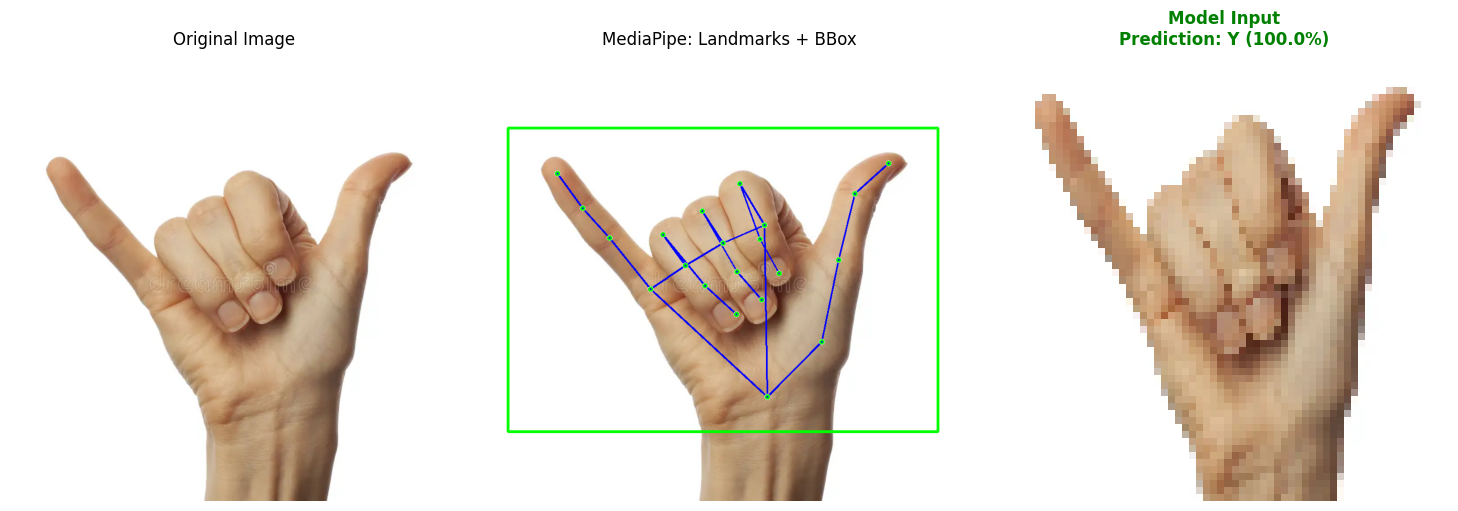

('Y', 100.0)

In [47]:
def test_external_image(img_path, model, class_names):

    print(f"Testing: {img_path}")

    preprocessed, success, viz_img = preprocess_external_image_with_mediapipe(img_path)

    if not success:
        print(f"❗Failed to preprocess image")
        return

    pred_probs = model.predict(preprocessed, verbose=0)[0]
    pred_idx = np.argmax(pred_probs)
    pred_label = class_names[pred_idx]
    confidence = pred_probs[pred_idx] * 100

    top_3_idx = np.argsort(pred_probs)[-3:][::-1]

    print(f"  🎯 Prediction: {pred_label}")
    print(f"  📊 Confidence: {confidence:.1f}%")
    print(f"  Top 3:")
    for i, idx in enumerate(top_3_idx, 1):
        print(f"    {i}. {class_names[idx]}: {pred_probs[idx]*100:.1f}%")

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    original = cv2.imread(img_path)
    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    axes[0].imshow(original)
    axes[0].set_title('Original Image', fontsize=12)
    axes[0].axis('off')

    if viz_img is not None:
        axes[1].imshow(viz_img)
        axes[1].set_title('MediaPipe: Landmarks + BBox', fontsize=12)
        axes[1].axis('off')

    axes[2].imshow(preprocessed[0])
    axes[2].set_title(f'Model Input\nPrediction: {pred_label} ({confidence:.1f}%)', fontsize=12, fontweight='bold', color='green' if confidence > 70 else 'orange')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    return pred_label, confidence

test_external_image('ty2.webp', model , CLASS_NAMES)

**SECTION 16: MODEL COMPARISON (BEST EPOCH & FINAL ONE)**

In [42]:
print("Loading models ...")

final_model_path = 'asl_final_cnn_mediapipe_model.keras'  
if os.path.exists(final_model_path):
    model_final = keras.models.load_model(final_model_path)
    print(f"Final model loaded: {final_model_path}")
else:
    print(f"Final model not found: {final_model_path}")
    exit(1)

checkpoint_model_path = 'best_asl_cnn_mediapipe_model.h5'
if os.path.exists(checkpoint_model_path):
    model_checkpoint = keras.models.load_model(checkpoint_model_path)
    print(f"Checkpoint model loaded: {checkpoint_model_path}")
else:
    print(f"Checkpoint model not found: {checkpoint_model_path}")
    exit(1)

Loading models ...


Final model loaded: asl_final_cnn_mediapipe_model.keras
Checkpoint model loaded: best_asl_cnn_mediapipe_model.h5


In [44]:
# evaluation function
def evaluate_model(model, model_name, X_train, y_train_cat, X_val, y_val_cat, X_test, y_test_cat):

    print(f"🐥 Evaluating: {model_name}")
    print("-"*70)
    
    results = {}
    
    # train set
    print("   Evaluating on training set...")
    train_loss, train_acc = model.evaluate(X_train, y_train_cat, verbose=0)
    results['train_loss'] = train_loss
    results['train_acc'] = train_acc
    print(f"   🐔 Train - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
    
    # val set
    print("   Evaluating on validation set...")
    val_loss, val_acc = model.evaluate(X_val, y_val_cat, verbose=0)
    results['val_loss'] = val_loss
    results['val_acc'] = val_acc
    print(f"   🐔 Val   - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
    
    # test set
    print("   Evaluating on test set...")
    test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
    results['test_loss'] = test_loss
    results['test_acc'] = test_acc
    print(f"   🐔 Test  - Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
    
    print("   Generating predictions...")
    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    results['predictions'] = y_pred
    results['prediction_probs'] = y_pred_probs
    
    return results

results_final = evaluate_model(
    model_final, "FINAL MODEL", 
    X_train, y_train_cat, X_val, y_val_cat, X_test, y_test_cat
)

results_checkpoint = evaluate_model(
    model_checkpoint, "CHECKPOINT MODEL (BEST)", 
    X_train, y_train_cat, X_val, y_val_cat, X_test, y_test_cat
)

🐥 Evaluating: FINAL MODEL
----------------------------------------------------------------------
   Evaluating on training set...
   🐔 Train - Loss: 0.0922, Accuracy: 0.9790 (97.90%)
   Evaluating on validation set...
   🐔 Val   - Loss: 0.0817, Accuracy: 0.9847 (98.47%)
   Evaluating on test set...
   🐔 Test  - Loss: 0.0867, Accuracy: 0.9792 (97.92%)
   Generating predictions...
🐥 Evaluating: CHECKPOINT MODEL (BEST)
----------------------------------------------------------------------
   Evaluating on training set...
   🐔 Train - Loss: 0.0922, Accuracy: 0.9790 (97.90%)
   Evaluating on validation set...
   🐔 Val   - Loss: 0.0817, Accuracy: 0.9847 (98.47%)
   Evaluating on test set...
   🐔 Test  - Loss: 0.0867, Accuracy: 0.9792 (97.92%)
   Generating predictions...


Training CNN model on the dataset that was re-annotated by mediapipe landmark and bbox does not overfit, and generalize well.